# Project YODA

In [4]:
!pip install git+https://github.com/steiningerjakob/Project-YODA

  Cloning https://github.com/steiningerjakob/Project-YODA to /private/var/folders/7t/thbtp8jj61gcvm_yjphlqfrc0000gn/T/pip-req-build-h0_xzlav
  Running command git clone --filter=blob:none -q https://github.com/steiningerjakob/Project-YODA /private/var/folders/7t/thbtp8jj61gcvm_yjphlqfrc0000gn/T/pip-req-build-h0_xzlav
  Resolved https://github.com/steiningerjakob/Project-YODA to commit 699e490de1e1bedc2649e1a60603ee912b016542
  Preparing metadata (setup.py) ... done


In [5]:
### standard data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from PIL import Image as PImage
### deep learning imports

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation
#from tensorflow.keras import optimizers
#from tensorflow.keras import callbacks
#from tensorflow.keras import utils

In [7]:
BUCKET_NAME = 'wagon-data-745-project-yoda'
BUCKET_DATA_PATH = 'raw_data'

In [15]:
def get_dataframes_from_gcp(optimize=False, **kwargs):
    """method to get the training data from google cloud bucket"""
    base_path = f"gs://{BUCKET_NAME}/{BUCKET_DATA_PATH}"
    index = pd.read_csv(f'{base_path}/index.csv')
    metadata = pd.read_csv(f'{base_path}/metadata.csv')
    df = pd.merge(index, metadata, on='class_id')

    # put all but 2 images of each class in training set, rest in validation set
    df_train = pd.DataFrame([])
    df_valid = pd.DataFrame([])
    for i in range(1,len(df['class_id'].value_counts())+1):
        df_train = df_train.append(df[df['class_id'] == i].iloc[ :-2])
        df_valid = df_valid.append(df[df['class_id'] == i].iloc[-2: ])

    return df_train, df_valid

In [16]:
df_train, df_valid = get_dataframes_from_gcp()

In [19]:
print(df_train.shape)
print(df_valid.shape)

(287, 5)
(74, 5)


## Data exploration

### Import data

In [2]:
index = pd.read_csv('../raw_data/index.csv')
index.head()

path  class_id
0  marvel/0001/001.jpg         1
1  marvel/0001/002.jpg         1
2  marvel/0001/003.jpg         1
3  marvel/0001/004.jpg         1
4  marvel/0001/005.jpg         1

In [3]:
metadata = pd.read_csv('../raw_data/metadata.csv')
metadata.head()

class_id lego_ids                 lego_names minifigure_name
0         1  [76115]  ['Spider Mech vs. Venom']      SPIDER-MAN
1         2  [76115]  ['Spider Mech vs. Venom']           VENOM
2         3  [76115]  ['Spider Mech vs. Venom']        AUNT MAY
3         4  [76115]  ['Spider Mech vs. Venom']    GHOST SPIDER
4         5  [75208]             ["Yoda's Hut"]            YODA

In [4]:
df = pd.merge(index, metadata, on='class_id')
df.head()

path  class_id lego_ids                 lego_names  \
0  marvel/0001/001.jpg         1  [76115]  ['Spider Mech vs. Venom']   
1  marvel/0001/002.jpg         1  [76115]  ['Spider Mech vs. Venom']   
2  marvel/0001/003.jpg         1  [76115]  ['Spider Mech vs. Venom']   
3  marvel/0001/004.jpg         1  [76115]  ['Spider Mech vs. Venom']   
4  marvel/0001/005.jpg         1  [76115]  ['Spider Mech vs. Venom']   

  minifigure_name  
0      SPIDER-MAN  
1      SPIDER-MAN  
2      SPIDER-MAN  
3      SPIDER-MAN  
4      SPIDER-MAN

In [5]:
len(df)

361

### Explore files

In [6]:
df.minifigure_name.value_counts()

SPIDER-MAN                     18
TRACKER TRAQUEUR RASTREADOR    12
OWEN GRADY                     12
YODA                           12
LUKE SKYWALKER                 12
R2-D2                          12
GENERAL GRIEVOUS               12
HARRY POTTER                   11
TASKMASTER                     11
YELENA BELOVA                  11
RON WEASLEY                    11
BLACK WIDOW                    11
MACE WINDU                     11
GHOST SPIDER                   10
IRON MAN MK 1                  10
EMPEROR PALPATINE              10
IRON MAN MK 50                 10
VENOM                          10
IRON MAN MK 41                 10
CAPTAIN AMERICA                10
OUTRIDER 1                     10
OUTRIDER 2                     10
IRON MAN MK 5                  10
AUNT MAY                       10
ANAKIN SKYWALKER                9
DARTH VADER                     9
OBI-WAN KENOBI                  9
KYLO REN                        8
JANNAH                          8
HAN SOLO      

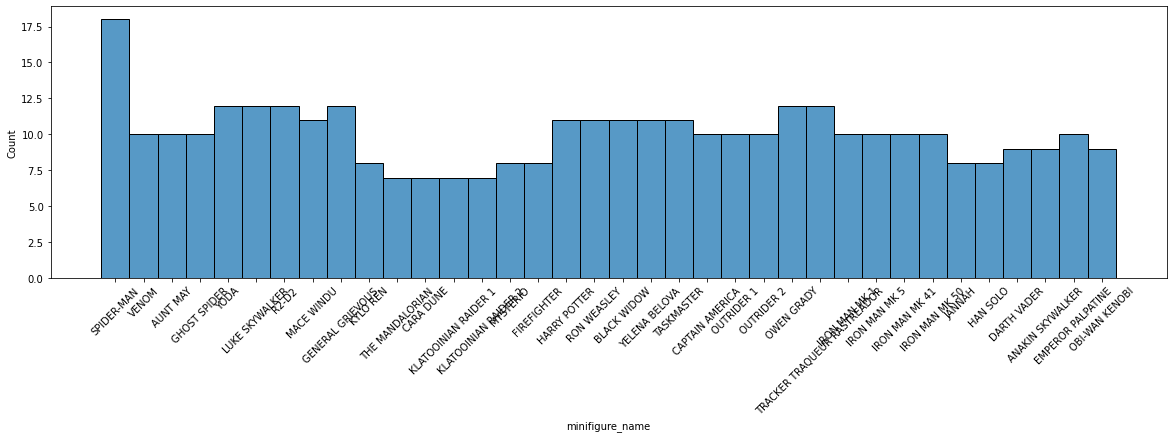

In [7]:
plt.figure(figsize=(20,5))
sns.histplot(df['minifigure_name'])
plt.xticks(rotation=45)
plt.show();

In [11]:
df_train = pd.DataFrame([])
df_valid = pd.DataFrame([])

for i in range(1,len(df['class_id'].value_counts())+1):
    df_train = df_train.append(df[df['class_id'] == i].iloc[ :-1])    
    df_valid = df_valid.append(df[df['class_id'] == i].iloc[-1: ])

In [46]:
df_valid.shape

(37, 5)

In [14]:
root_dir = "../raw_data/"

In [28]:
def loadImages(root_dir, df):
    

    loadedImages = []
    for image in df['path']:
        img = PImage.open(root_dir + image)
        loadedImages.append(img)
    

    return loadedImages


# your images in an array
imgs = loadImages(root_dir, df)


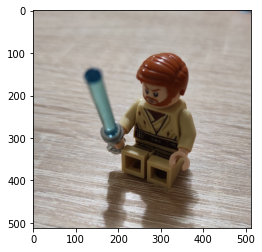

In [34]:
import matplotlib.pyplot as plt
plt.imshow(imgs[360])

### Preprocess data (if necessary)

In [43]:
len(df.minifigure_name.unique())

36

In [63]:
#https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1

datagen=ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=root_dir, x_col="path", y_col="minifigure_name", class_mode="categorical", target_size=(256,256), batch_size=16)
valid_generator=datagen.flow_from_dataframe(dataframe=df_valid, directory=root_dir, x_col="path", y_col="minifigure_name", class_mode="categorical", target_size=(256,256), batch_size=16, shuffle=False)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation='softmax'))

model.compile(optimizers.Adam(lr=0.01),
loss="categorical_crossentropy", metrics=["accuracy"])


Found 324 validated image filenames belonging to 36 classes.
Found 37 validated image filenames belonging to 36 classes.


2021-11-23 11:57:54.747169: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503840768 exceeds 10% of free system memory.
2021-11-23 11:57:55.950412: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503840768 exceeds 10% of free system memory.
/home/hiczer/.pyenv/versions/3.8.12/envs/Project-YODA/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 32)      0         
                                                      

In [ ]:
es = callbacks.EarlyStopping(patience=2, monitor='val_accuracy', restore_best_weights=True)

model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    callbacks=[es],
                    verbose=1,
                    epochs=10)

/tmp/ipykernel_11283/3407511057.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/10
21/21 [==============================] - 213s 10s/step - loss: 116.6449 - accuracy: 0.0185 - val_loss: 3.5821 - val_accuracy: 0.0541
Epoch 2/10
 8/21 [==========>...................] - ETA: 2:27 - loss: 3.5770 - accuracy: 0.0517

### ...

## Classification model

### Define initial model architecture 

### Train initial model